# Using mean-field TEMPO (TempoWithField)
In this tutorial we discuss how the TEMPO and PT-TEMPO methods may be used to compute the dynamics of a many-body system of the type introduced in [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)).
### Contents
  1. Background and introduction
    * many-body system and environment Hamiltonians
    * system Hamiltonian and field equation of motion after the mean-field reduction
  2. Creating time-dependent system with field and bath objects
  3. TEMPO computation for single dynamics
  4. PT-TEMPO computation for multiple sets of dynamics

We firstly import OQuPy and other useful packages:

In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt

Check the current OQuPy version; mean-field functionality was introduced in version **?.?.0**

In [2]:
oqupy.__version__

'0.2-dev'

The following matrices will be useful below:

In [3]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

-------------------------------------------------
# 1. Background and introduction

Our goal will be to reproduce a line from **Fig. 2a.** of [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)) which shows the photon number dynamics for the driven-dissipative system of molecules in a single-mode cavity.

## Many-body system and environment Hamiltonian
The Hamiltonian describing the many-body system with one-to-all light-matter coupling is
$$
H_{S} = \omega_c a^{\dagger}_{}a^{\vphantom{\dagger}}_{} 
	+ \sum_{i=1}^N \left[\frac{\omega_0}{2} \sigma^z_i
	+  \frac{\Omega}{2\sqrt{N}} \left( a^{\vphantom{\dagger}}_{} \sigma^+_i + a^{\dagger}_{} \sigma^-_i \right)\right]
$$
Together with the vibrational environment of each molecule,
$$
	H_{E}^{(i)} = \sum_{j} \left[	\nu_{j} b^{\dagger}_{j} b^{\vphantom{\dagger}}_{j} 
	+ \frac{\xi_{j}}{2} (b^{\vphantom{\dagger}}_{j}+b^{\dagger}_{j})\sigma^z_i\right]\text{.}
$$
This is taken to be a continuum of low frequency modes with coupling characterized by a spectral density with a 'Gaussian' cut-off
$$
\begin{align*}
J(\nu) &= \sum_{j}  \left(\frac{\xi_j}{2}\right)^2
\delta(\nu-\nu_j)= 2\alpha \nu e^{-(\nu/\nu_c)^2}\text{,} \quad \nu>0\text{,}
\end{align*}
$$
where $\alpha=0.25$ and $\nu_c=0.15$ eV for the environment of BODIPY-Br considered in the Letter. Other system and environment parameters relevant to **Fig. 2a.** are, in units of eV,
* $T=0.026$ $\left(300 \text{K}\right)$ - environment temperature
* $\omega_0=0$ - two-level system frequency **\***
* $\omega_c=-0.02$ - bare cavity frequency
* $\Omega=0.2$ - collective light-matter coupling

together with the rates
* $\kappa=0.01$ - field decay
* $\Gamma_\downarrow = 0.01$ - electronic dissipation
* $\Gamma_\uparrow \in (0.2\Gamma_\downarrow,0.8\Gamma_\downarrow) $ - electronic pumping

The latter appear as prefactors for Markovian terms in the quantum master equation for the total density operator
$$
		\partial_t \rho = -i \biggl[ H_S + \sum_{i=1}^N H_E^{(i)}, \rho \biggr]
	+ 2 \kappa \mathcal{L}[a^{\vphantom{\dagger}}_{}]
	+ \sum_{i=1}^N (\Gamma_\uparrow \mathcal{L}[\sigma^+_i]
	+  \Gamma_\downarrow \mathcal{L}[\sigma^-_i])\text{.}
$$
As indicated, it is the pump strength $\Gamma_\uparrow$ that is varied to generate the different lines of **Fig. 2a.** In this tutorial we generate the $\Gamma_\uparrow=0.8$ line using the TEMPO method, and then the Process Tensor approach to calculate all of the lines efficiently.  

The following code box defines each of the above parameters.


**\* N.B.** for calculating the dynamics only the detuning $\omega_c-\omega_0$ is relevant, so we set $\omega_0=0$ for convenience.

In [4]:
alpha = 0.25
nu_c = 0.15
T = 0.026
omega_0 = 0.0
omega_c = -0.02
Omega = 0.2

kappa = 0.01
Gamma_down = 0.01
Gamma_up = 0.8 * Gamma_down

### System Hamiltonian and field equation of motion after the mean-field reduction

The mean-field approach is based on a product-state ansatz for the total density operator $\rho$,
$$
\rho = \rho_a \otimes \bigotimes_{i=1}^N \rho_i,\quad \rho_a= \text{Tr}_{\otimes{i}}\rho,\quad \rho_i = \text{Tr}_{a, \otimes{j\neq i}} \rho,
$$ 
where $\text{Tr}_{\otimes{i}}$ denotes a partial trace taken over the Hilbert space of all two-level systems and $\text{Tr}_{a, \otimes{j\neq i}}$ the trace over the photonic degree of freedom and all but the $i^{\text{th}}$ two-level system. As detailed in the Supplement of the Letter, after rescaling the field $\langle a \rangle \to \langle a \rangle/\sqrt{N}$ ($\langle a \rangle$ scales with $\sqrt{N}$ in the lasing phase), the dynamics are controlled by the mean-field Hamiltonian $H_{\text{MF}}$ for a *single molecule,*
$$
	H_\text{MF} = 
 \frac{\omega_0}{2}\sigma^z+
	\frac{\Omega}{2}\left( \langle a \rangle \sigma^+ +
	\langle a \rangle^{*}\sigma^- \right)\text{,}
$$
together with the equation of motion for the field $\langle a \rangle$,
$$
\partial_t \langle a \rangle = 
	- (i\omega_c+\kappa)\langle a \rangle- i \frac{\Omega}{2}\langle\sigma^-\rangle.
$$
Therefore in order to calculate the dynamics we need to encode the field's equation of motion in addition to the Hamiltonian for a single two level-system $\rho_i$ (which we identify as the 'system' in our TEMPO computation). 

In OQuPy, the relevant classes and methods hence all have the `WithField` suffix: `TimeDependentSystemWithField`, `DynamicsWithField`, `TempoWithField` (TEMPO) and `compute_dynamics_with_field()` (PT-TEMPO).

# 2. Creating time-dependent system with field and bath objects
A `TimedependentSystemWithField` object requires two physical inputs: a Hamiltonian, which is a function of time $t$ and field $\langle a \rangle$ (in that order), and a equation of motion for the field, which is a function of time $t$, system state $\rho_i$ and field $\langle a \rangle$. Positional arguments are used for these functions, so the order of arguments matters whilst their name does not:**\***

In [5]:
def H_MF(t, a):
    return 0.5 * omega_0 * sigma_z +\
        0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)
def field_eom(t, state, a):
    expect_val = np.matmul(sigma_minus, state).trace()
    return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

Note $\rho_i$ is provided as a $2\times2$ matrix, hence to compute the expectation $\langle \sigma^- \rangle$ we used matrix multiplication with $\sigma^-$ and took the trace. It's a good idea to test these functions:

In [6]:
test_field = 1.0+1.0j
test_time = 1.0
test_state = np.array([[0.0,2j],[-2j,1.0]])
print('H_eval =', H_MF(test_time, test_field))
print('EOM_eval =', field_eom(test_time, test_state, test_field))

H_eval = [[0. +0.j  0.1+0.1j]
 [0.1-0.1j 0. +0.j ]]
EOM_eval = (0.17+0.01j)


Secondly, we need to specify Lindblad operators for the pumping and dissipation processes:

In [7]:
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [ lambda t: sigma_minus, lambda t: sigma_plus]

Here the rates and Lindblad operators must be callables taking a single argument - time - even though in our example there is no time-dependence (see **\*** below). The system-field object is then constructed with

In [8]:
system = oqupy.TimeDependentSystemWithField(
        H_MF,
        field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

Correlations and a Bath object are created in the same way as in any other TEMPO computation (refer to preceding tutorials):

In [9]:
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)
bath = oqupy.Bath(0.5 * sigma_z, correlations)

**\*** In particular both functions must have a first argument representing time, even if the problem - as here - has no explicit time-dependence (for codebase simplicity there is no `SystemWithField` class).

# 3. TEMPO computation for single dynamics

For our simulations we use the same initial conditions for the system and state used in the Letter:

In [10]:
initial_field = np.sqrt(0.05) # Note n_0 = <a^dagger a>(0) = 0.05
initial_state = np.array([[0,0],[0,1]]) # spin down

To reduce the computation time we simulate only part of the dynamics. We also lower the memory cut-off and precision relative to the Letter and use a four times more coarse timesteps:

In [11]:
tempo_parameters = oqupy.TempoParameters(dt=2.4, dkmax=40, epsrel=10**(-5))
start_time = 0.0
end_time = 250.0

The only subtlety here is that the units of time are those with $\hbar=1$; you can check $t=250$ corresponds to $t=1$ ps in SI units.
The `oqupy.TempoWithField.compute` method may then be used to compute the dynamics in exactly the same way a call to `oqupy.Tempo.compute` is used to compute the dynamics for an ordinary `System` or `TimeDependentSystem`:

In [12]:
tempo_sys = oqupy.TempoWithField(system=system,
                                 bath=bath,
                                 initial_state=initial_state,
                                 initial_field=initial_field,
                                 start_time=start_time,
                                 parameters=tempo_parameters)
dynamics_with_field = tempo_sys.compute(end_time=end_time)

--> TEMPO-with-field computation:
101.0%  105 of  104 [########################################] 00:00:28
Elapsed time: 28.4s


`TempoWithField.compute` returns a `DynamicsWithField` object containing both the state matrices and field values at each timestep, in addition to the timesteps themselves:

In [13]:
times = dynamics_with_field.times
states = dynamics_with_field.states
fields = dynamics_with_field.fields

We plot a the square value of the fields i.e. the photon number, producing the first part of a single line of **Fig. 2a.**:

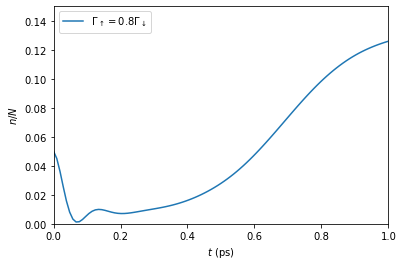

In [15]:
n = np.abs(fields)**2
plt.plot(times/250, n, label=r'$\Gamma_\uparrow = 0.8\Gamma_\downarrow$')
plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.xlim((0.0,1.0))
plt.ylim((0.0,0.15))
plt.legend(loc='upper left')

If you have the time you can calculate the dynamics to $t=2000$ as in the Letter and check that, even for these rough parameters, the results are reasonable close to being converged with respect to `dt`, `dkmax` and `epsrel`.

While you could repeat the TEMPO computation for each pump strength $\Gamma_\uparrow$ appearing in **Fig. 2a.**, a more efficient solution for calculating dynamics for multiple sets of system parameters (in this case Lindblad rates) is provided by PT-TEMPO.

# 4. PT-TEMPO computation for multiple sets of dynamics
The above calculation can be performed quickly for many-different pump strengths  $\Gamma_\uparrow$ using a single process tensor. 

As discussed in the Supplement Material for the Letter, there is no guarantee that computational parameters that gave a set of converged results for the TEMPO method will give converged results for a PT-TEMPO calculation. For the sake of this tutorial however let's assume the above parameters continue to be reasonable. The process tensor to time $t=500$ ($2$ ps) is calculated using these parameters and the bath via

In [16]:
process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0.0,
                                        end_time=250,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  104 of  104 [########################################] 00:00:12
Elapsed time: 12.2s


Refer the Time Dependence and PT-TEMPO tutorial for further discussion of the process tensor.

To calculate the dynamics for the 4 different pump strengths in **Fig. 2a.**, we define a separate system with field object for each pump strength. Only the `gammas` array needs to be modified constructor calls:

In [17]:
pump_ratios = [0.2, 0.4, 0.6, 0.8]
systems = []
for ratio in pump_ratios:
    Gamma_up = ratio * Gamma_down
    # N.B. a default argument is used to avoid the late-binding closure issue
    # discussed here: https://docs.python-guide.org/writing/gotchas/#late-binding-closures
    gammas = [ lambda t: Gamma_down, lambda t, Gamma_up=Gamma_up: Gamma_up]
     # Use the same Hamiltonian, equation of motion and Lindblad operators
    system = oqupy.TimeDependentSystemWithField(H_MF,
        field_eom,
        gammas=gammas,
        lindblad_operators=lindblad_operators)
    systems.append(system)

We can then use `compute_dynamics_with_field` to compute the dynamics at each $\Gamma_\uparrow$ for the particular initial condition using the process tensor calculated above:

In [18]:
t_list = []
n_list = []
for i,system in enumerate(systems):
    dynamics = oqupy.compute_dynamics_with_field(
        process_tensor=process_tensor,
        system=system,
        initial_state=initial_state,
        initial_field=initial_field,
        start_time=0.0)
    t = dynamics.times
    fields = dynamics.fields
    n = np.abs(fields)**2
    t_list.append(t)
    n_list.append(n)

--> Compute dynamics with field:
100.0%  105 of  105 [########################################] 00:00:17
Elapsed time: 17.8s
--> Compute dynamics with field:
100.0%  105 of  105 [########################################] 00:00:18
Elapsed time: 18.3s
--> Compute dynamics with field:
100.0%  105 of  105 [########################################] 00:00:18
Elapsed time: 18.6s
--> Compute dynamics with field:
100.0%  105 of  105 [########################################] 00:00:17
Elapsed time: 17.8s


Finally, plotting the results:

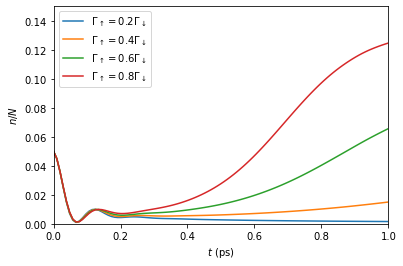

In [19]:
for i,n in enumerate(n_list):
    ratio = pump_ratios[i]
    label = r'$\Gamma_\uparrow = {}\Gamma_\downarrow$'.format(pump_ratios[i])
    plt.plot(t_list[i]/250, n_list[i], label=label)
plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.xlim((0.0,1.0))
plt.ylim((0.0,0.15))
plt.legend(loc='upper left')